In [18]:
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter, convolve

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import cartopy.crs as ccrs
import cartopy

import xarray as xr
import glob
import time
from xarray.ufuncs import cos, deg2rad

# Functions, etc

In [19]:
def gaussian_isotropic(x,y,sigma):
    return np.exp(-1/(2*sigma**2)*(x**2+y**2))

def gaussian(x,y,invcov):
    return np.exp(-1/2 * (invcov[0,0]*x**2 + (invcov[1,0]+invcov[0,1])*x*y + invcov[1,1]*y**2))

def u_invcov(u,v,alpha,sigma):
    sigma1 = sigma*np.sqrt(2/(1+alpha**2))#scaled std so that total variance = sigma**2
    rotation_matrix = 1/np.sqrt(u**2+v**2) * np.array([[u,v],[-v,u]])
    diag_matrix = np.diag([1/(alpha*sigma1)**2,1/sigma1**2])
    return np.dot(np.dot(rotation_matrix,diag_matrix),np.transpose(rotation_matrix))

def convolveCustom(f,g,mode='wrap'):
    """2D convolution with a space-varying kernel g
        g must have shape (f.shape[0],f.shape[1],ng,mg) where (ng,mg) is the kernel shape at each point"""
    rep=np.zeros(f.shape)
    ng,mg = g.shape[2:4]
    fpad = np.pad(f,(ng,mg),mode=mode)
    for i in range(f.shape[0]):
        for j in range(f.shape[1]):
            rep[i,j] = np.sum(g[i,j][::-1,::-1]*fpad[ng+i- ng//2 : 2*ng+i- ng//2,mg+j- mg//2 : 2*mg+j- mg//2])
            
    return rep


def spaceVaryingAnisotropicKernel(U,V,sigma):
    """Return a space-varying kernel (of shape (f.shape[0],f.shape[1],ng,ng))
    where ng=4*int(sigma) is the kernel size at each point
    The kernel is basically consituted of two parts :
     - an upstream part, which is an anisotropic gaussian kernel with total variance sigma**2,
       and a std that is alpha times bigger along the vector (U[i,j],V[i,j]) than along its orthogonal direction
       where alpha depends on the vector norm
     - a downstream part that is an isotropic gaussian kernel with total variance sigma'**2 
     (sigma' chosen to match upstream kernel shape)
    """
    assert U.shape==V.shape
    kernel_size=2*int(np.ceil(sigma))
    rep = np.zeros((U.shape[0],U.shape[1],2*kernel_size+1,2*kernel_size+1))
    X_kernel,Y_kernel = np.meshgrid(np.arange(-kernel_size,kernel_size+1),np.arange(-kernel_size,kernel_size+1))

    for i in range(U.shape[0]):
        for j in range(U.shape[1]):    
            # compute the upstream half of the kernel
            u,v = U[i,j],V[i,j]
            alpha = 1+np.sqrt((u**2+v**2))
            invcov = u_invcov(u,v,alpha,sigma) #inverse covariance matrix on the upstream half of the kernel
            gauss_kernel_aniso = gaussian(X_kernel,Y_kernel,invcov)
            
            #compute the downstream half of the kernel; sigma is modified to accound for the distortion of the upstream kernel
            gauss_kernel_iso = gaussian_isotropic(X_kernel,Y_kernel,sigma*np.sqrt(2/(1+alpha**2)))
            
            #final kernel is split between upstream anisotropic part and downstream isotropic part
            gauss_kernel_final = gauss_kernel_aniso*(u*X_kernel-v*Y_kernel<=0)+gauss_kernel_iso*(u*X_kernel-v*Y_kernel>0)
            rep[i,j] = gauss_kernel_final/np.sum(gauss_kernel_final)
            
    return rep

    

In [20]:
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"

def climatology_era5(year1,year2,varid):
    """Compute the monthly climatology of a 3D or 4D ERA5 variable for years between year1 and year2 (included),
    year1/2 must be of the type "yyyy"
    varid gives the id of the variable in era5, e.g. '128_135_w' for omega
    mnth is an str that gives the month to be considered
    """
    path = "/global/homes/w/wboos/m3310project/wboos/era5monthlyQuentin/"
    path2 = "/global/cscratch1/sd/qnicolas/era5monthly/"
    
    era5varsum = 0
    count = int(year2)+1-int(year1)
    era5varlist = []
    for y in [str(year) for year in range(int(year1),int(year2)+1)]:
        try :
            era5var = xr.open_dataset(glob.glob(path+"*/e5.*.%s.*.%s*.nc"%(varid,y))[0])
        except IndexError:
            era5var = xr.open_dataset(glob.glob(path2+"*/e5.*.%s.*.%s*.nc"%(varid,y))[0])
        varname = list(era5var.data_vars)[0] #get name of the main variable, eg 'W' for omega
        era5var1 = era5var[varname]
        era5varlist.append(era5var1)
    climatology = xr.concat(era5varlist,"time").groupby("time.month").mean("time")
    return climatology

def spatial_mean(ds):
    """Compute spatial mean of a DataArray"""
    if type(ds)==int:
        return ds
    coslat = cos(deg2rad(ds.latitude))
    weight_factor = coslat / coslat.mean('latitude')
    return (ds*weight_factor).mean(['latitude','longitude'])

def precip_pct(mask,precipmap,globmask=1):
    """Return the share of precipitation (in %) inside 'globmask' (whole world if globmask=1)
    that falls inside 'mask'. """
    mask2 = mask.interp_like(precipmap)
    if type(globmask)==int and globmask==1 :
        globmask2=1
    else :
        globmask2 = globmask.interp_like(precipmap)
    return 100*np.array(spatial_mean(mask2*globmask2*precipmap))/np.array(spatial_mean(globmask2*precipmap))

def objfunction_iso_smoothing(thresh,pr,predictor,globmask=1):
    """Given the map of a precipitation predictor (for example the upslope flow u.grad(z)),
    compute a mask accoding to predictor>thresh and compute the according precip enhancement and area fractions"""
    
    dx = np.abs(np.array(predictor.latitude[1]-predictor.latitude[0])) #get the spatial resolution of the predictor to smooth accordingly
    mask=1.*(xr.apply_ufunc(gaussian_filter,1.*(predictor>thresh),kwargs={"sigma":0.5/dx})>0.1)
    mask=mask.interp_like(pr)
    if type(globmask)!=int:
        globmask = globmask.interp_like(pr)
    area_fraction = spatial_mean(mask*globmask)/spatial_mean(globmask)
    precip_fraction = precip_pct(mask,pr,globmask)/100
    return 100*np.array(precip_fraction/area_fraction-1), 100*area_fraction

def objfunction_aniso_smoothing(thresh,pr,predictor,kernel):
    dx = np.abs(np.array(predictor.latitude[1]-predictor.latitude[0])) #get the spatial resolution of the predictor to smooth accordingly
    unsmoothed_xr=1.*(predictor>thresh)
    t=time.time()
    rainyregion_smoothed = 1.*(convolveCustom(np.array(unsmoothed_xr),kernel)>0.01)
    print(time.time()-t)
    mask=xr.DataArray(rainyregion_smoothed,unsmoothed_xr.coords)
    mask=mask.interp_like(pr)
    area_fraction = spatial_mean(mask)
    precip_fraction = precip_pct(mask,pr)/100
    return 100*np.array(precip_fraction/area_fraction-1), 100*area_fraction
    
def plotpct(ax,objfunction,lbl,args):
    #Get the range of thresholds to use on the predictor
    predictor = args[1]
    maxtresh = 0.5*np.max(np.array(predictor))
    ts = np.linspace(0.,maxtresh,10)
    
    x = np.array([objfunction(*tuple([t]+list(args))) for t in ts])
    precip_enhancements = x[:,0]
    area_fractions = x[:,1]
    
    print("threshold for 10%% : %.1e"%np.interp(10,area_fractions[::-1],ts[::-1]))
    
    ax.plot(area_fractions,precip_enhancements,'-x',label=lbl)
    ax.set_xscale('log')
    ax.set_xlim(100,0.5)

    ax.legend()
    ax.set_xlabel("Area fraction")
    ax.set_ylabel("Precipitation enhancement")
    ax.grid()


In [21]:
ERA5M_PATH = "/global/project/projectdirs/m3310/wboos/era5monthly/"
pr_era5_all = 1000*xr.open_dataset(ERA5M_PATH+"era5_monthly_slev_1979-2019.nc").tp
pr_era5_mnthmean = pr_era5_all.groupby("time.month").mean("time")
pr_era5_mean = pr_era5_all.mean("time")

pr_trmm_all=xr.open_dataset("/global/cscratch1/sd/wboos/data/trmm/pr_TRMM-L3_v7-7A_199801-201312.nc").pr.rename({'lat':'latitude','lon':'longitude'})*3600*24
pr_trmm_mnthmean = pr_trmm_all.groupby("time.month").mean("time")
pr_trmm_mean = pr_trmm_mnthmean.mean('month')

In [22]:
#OROGRAPHY
orog1 = xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc")
orog=orog1.Z.isel(time=0)/9.80665

m_per_degreelat = 6370*1e3*np.pi/180

coslat = np.cos(orog.latitude*np.pi/180.)
coslat += 1e-5*(1-1*(coslat>1e-5))

ddxorog = orog.differentiate("longitude")/(m_per_degreelat*coslat)
ddyorog = orog.differentiate("latitude")/m_per_degreelat

#latitude step in era5
dx5 = np.abs(np.array(ddxorog.latitude.isel(latitude=1)-ddxorog.latitude.isel(latitude=0)))

#LAND MASK
landmask = xr.open_dataset("/global/cfs/projectdirs/m3522/cmip6/ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc").LSM.isel(time=0)

In [23]:
u100m_era5_mnthmean = climatology_era5("2010","2013",'228_246_100u')
v100m_era5_mnthmean = climatology_era5("2010","2013",'228_247_100v')

ugradz_era5_mnthmean = (u100m_era5_mnthmean*ddxorog + v100m_era5_mnthmean*ddyorog)
ugradz_era5_mean = ugradz_era5_mnthmean.mean('month')
ugradz_era5_mean_s  = xr.apply_ufunc(gaussian_filter,ugradz_era5_mean  ,kwargs={"sigma":.5/dx5})



In [24]:
pw_era5_mnthmean    = climatology_era5("2010","2013",'128_137_tcwv')
pw_ugradz_era5_mnthmean = pw_era5_mnthmean*ugradz_era5_mnthmean
pw_ugradz_era5_mean  = pw_ugradz_era5_mnthmean.mean('month')
pw_ugradz_era5_mean_2 = pw_era5_mnthmean.mean('month')*ugradz_era5_mean

pw_ugradz_era5_mean_s  = xr.apply_ufunc(gaussian_filter,pw_ugradz_era5_mean  ,kwargs={"sigma":.5/dx5})
pw_ugradz_era5_mean_2_s= xr.apply_ufunc(gaussian_filter,pw_ugradz_era5_mean_2,kwargs={"sigma":.5/dx5})


In [25]:
q925_era5_mnthmean = climatology_era5("2010","2013",'128_133_q').sel(level=925.)
q925_ugradz_era5_mnthmean = q925_era5_mnthmean*ugradz_era5_mnthmean
#q925_ugradz_era5_mean  = q925_ugradz_era5_mnthmean.mean('month')
q925_ugradz_era5_mean  = q925_era5_mnthmean.mean('month')*ugradz_era5_mean
q925_ugradz_era5_mean_s  = xr.apply_ufunc(gaussian_filter,q925_ugradz_era5_mean  ,kwargs={"sigma":.5/dx5})

In [73]:
uq_era5_mnthmean    = climatology_era5("2010","2013",'162_071_viwve')
vq_era5_mnthmean    = climatology_era5("2010","2013",'162_072_viwvn')
vimt_gradz_era5_mnthmean = uq_era5_mnthmean*ddxorog + vq_era5_mnthmean*ddyorog
vimt_gradz_era5_mean  = vimt_gradz_era5_mnthmean.mean('month')
vimt_gradz_era5_mean_s  = xr.apply_ufunc(gaussian_filter,vimt_gradz_era5_mean  ,kwargs={"sigma":.5/dx5})


In [27]:
u100m_era5_mean = u100m_era5_mnthmean.mean('month')
v100m_era5_mean = v100m_era5_mnthmean.mean('month')

In [28]:
def timesel(month,monthinf,monthsup):
    return (np.mod(month - monthinf,12) < np.mod(monthsup - monthinf,12)) & (np.mod(monthsup - month,12) <= np.mod(monthsup - monthinf,12))

q925_ugradz_era5_seasonal = []
pr_trmm_seasonal = []
pr_era5_seasonal = []
u100m_era5_seasonal = []
v100m_era5_seasonal = []

for season in [(12,3),(3,6),(6,9),(9,12)]:
    q925_ugradz_era5_seasonal.append( q925_ugradz_era5_mnthmean.sel(month = timesel(q925_ugradz_era5_mnthmean['month'],season[0],season[1])).mean('month') )
    pr_trmm_seasonal.append(pr_trmm_mnthmean.sel(month = timesel(pr_trmm_mnthmean['month'],season[0],season[1])).mean('month'))
    pr_era5_seasonal.append(pr_era5_mnthmean.sel(month = timesel(pr_era5_mnthmean['month'],season[0],season[1])).mean('month'))
    u100m_era5_seasonal.append(u100m_era5_mnthmean.sel(month = timesel(pr_era5_mnthmean['month'],season[0],season[1])).mean('month'))
    v100m_era5_seasonal.append(v100m_era5_mnthmean.sel(month = timesel(pr_era5_mnthmean['month'],season[0],season[1])).mean('month'))
    

# Land + Ocean

## All-year mean

threshold for 10% : 5.1e-02
threshold for 10% : 1.6e-05
threshold for 10% : 5.1e-02
threshold for 10% : 1.6e-05
threshold for 10% : 3.6e-02
threshold for 10% : 1.4e-05


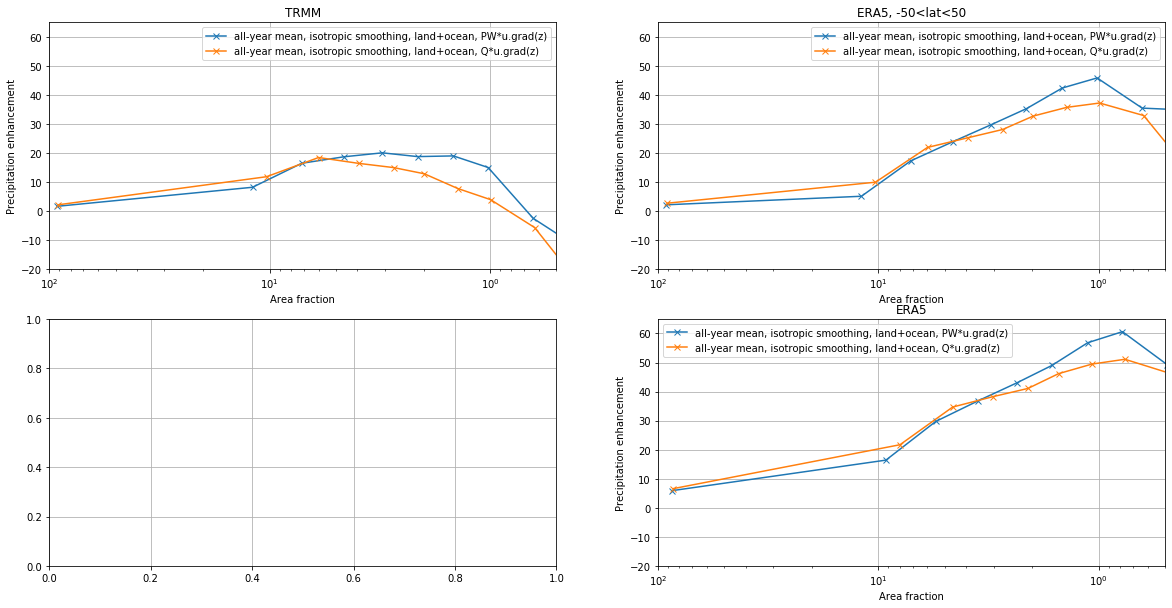

In [29]:
_,ax = plt.subplots(2,2,figsize=(20,10))

plotpct(ax[0][0],objfunction_iso_smoothing,"all-year mean, isotropic smoothing, land+ocean, PW*u.grad(z)",[pr_trmm_mean,pw_ugradz_era5_mean_s  ])
plotpct(ax[0][0],objfunction_iso_smoothing,"all-year mean, isotropic smoothing, land+ocean, Q*u.grad(z)", [pr_trmm_mean,q925_ugradz_era5_mean_s])
ax[0][0].set_title("TRMM")
ax[0][0].set_ylim(-20,65)

plotpct(ax[0][1],objfunction_iso_smoothing,"all-year mean, isotropic smoothing, land+ocean, PW*u.grad(z)",[pr_era5_mean.sel(latitude=slice(50,-50)),pw_ugradz_era5_mean_s  ])
plotpct(ax[0][1],objfunction_iso_smoothing,"all-year mean, isotropic smoothing, land+ocean, Q*u.grad(z)", [pr_era5_mean.sel(latitude=slice(50,-50)),q925_ugradz_era5_mean_s])
ax[0][1].set_title("ERA5, -50<lat<50")
ax[0][1].set_ylim(-20,65)

plotpct(ax[1][1],objfunction_iso_smoothing,"all-year mean, isotropic smoothing, land+ocean, PW*u.grad(z)",[pr_era5_mean,pw_ugradz_era5_mean_s  ])
plotpct(ax[1][1],objfunction_iso_smoothing,"all-year mean, isotropic smoothing, land+ocean, Q*u.grad(z)", [pr_era5_mean,q925_ugradz_era5_mean_s])
ax[1][1].set_title("ERA5")
ax[1][1].set_ylim(-20,65)

for a in ax.reshape(-1): a.grid()


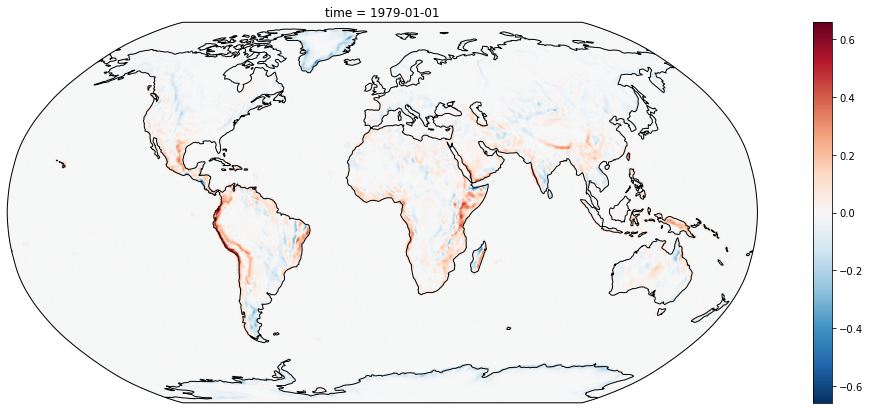

In [30]:
#mask=1.*(xr.apply_ufunc(gaussian_filter,1.*(pw_ugradz_era5_mean_s>0.2),kwargs={"sigma":0.5/dx5})>0.1)

m=20.;kw = {'levels':[0.5], 'colors':['w']}
fig, (ax1) = plt.subplots(1,1,figsize=(20,7),subplot_kw={'projection': ccrs.Robinson()})
#pr_trmm_mean.plot(ax=ax1,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,m+1,m/4)},levels=np.linspace(0.,m,50))
#mask.sel(latitude=slice(50., -50.)).plot.contour(ax=ax1,transform=ccrs.PlateCarree(),**kw)

pw_ugradz_era5_mean_s.plot(ax=ax1,transform=ccrs.PlateCarree())

ax1.coastlines()
#ax1.set_title("Isotropic smoothing, Area fraction : %.1f%%, precip enhancement : %.1f%%"%(100*spatial_mean(upslope_qw_thresh_era5_07_s),100*np.array(precip_pct(upslope_qw_thresh_era5_07_s,pr_trmm_mean07)/spatial_mean(upslope_qw_thresh_era5_07_s)/100-1)))


## Seasonal means

threshold for 10% : 5.7e-05
threshold for 10% : 5.7e-05
threshold for 10% : 5.6e-05
threshold for 10% : 5.5e-05
threshold for 10% : 5.5e-05
threshold for 10% : 5.4e-05
threshold for 10% : 6.9e-05
threshold for 10% : 6.9e-05
threshold for 10% : 6.7e-05
threshold for 10% : 5.5e-05
threshold for 10% : 5.5e-05
threshold for 10% : 5.4e-05


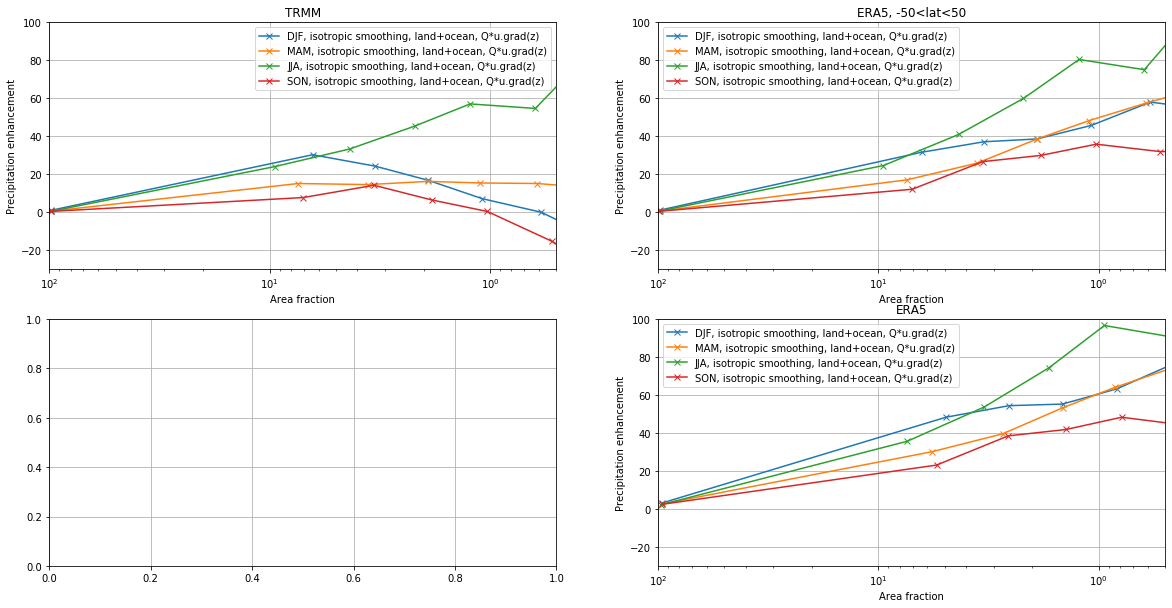

In [31]:
_,ax = plt.subplots(2,2,figsize=(20,10))

for season,seasonname in enumerate(['DJF','MAM','JJA','SON']):
    plotpct(ax[0][0],objfunction_iso_smoothing,"%s, isotropic smoothing, land+ocean, Q*u.grad(z)"%seasonname,[pr_trmm_seasonal[season],q925_ugradz_era5_seasonal[season] ])
    ax[0][0].set_ylim(-30,100)
    ax[0][0].set_title("TRMM")
    
    plotpct(ax[0][1],objfunction_iso_smoothing,"%s, isotropic smoothing, land+ocean, Q*u.grad(z)"%seasonname,[pr_era5_seasonal[season].sel(latitude=slice(50,-50)),q925_ugradz_era5_seasonal[season] ])
    ax[0][1].set_title("ERA5, -50<lat<50")
    ax[0][1].set_ylim(-30,100)
    
    plotpct(ax[1][1],objfunction_iso_smoothing,"%s, isotropic smoothing, land+ocean, Q*u.grad(z)"%seasonname,[pr_era5_seasonal[season],q925_ugradz_era5_seasonal[season] ])
    ax[1][1].set_title("ERA5")
    ax[1][1].set_ylim(-30,100)

for a in ax.reshape(-1): a.grid()
    

# With anisotropic smoothing

In [32]:
t=time.time()
kernel_mean = spaceVaryingAnisotropicKernel(np.array(u100m_era5_mean),np.array(v100m_era5_mean),4)
print(time.time()-t)

In [32]:
kernel_seasonal = []
for i in range(4):
    kernel_seasonal.append(spaceVaryingAnisotropicKernel(np.array(u100m_era5_seasonal[i]),np.array(v100m_era5_seasonal[i]),4))
    print(time.time()-t)

311.6017105579376


KeyboardInterrupt: 

In [ ]:
kernel_seasonal[3].shape

In [ ]:
_,ax = plt.subplots(1,1,figsize=(15,5))

plotpct(ax,objfunction_iso_smoothing,"all-year mean, isotropic smoothing, land+ocean, Q*u.grad(z)", [pr_era5_mean,q925_ugradz_era5_mean_s])
plotpct(ax,objfunction_aniso_smoothing,"all-year mean, anisotropic smoothing, land+ocean, Q*u.grad(z)", [pr_era5_mean,q925_ugradz_era5_mean_s,kernel_mean])
ax.set_title("ERA5")
ax.grid()

In [ ]:
_,ax = plt.subplots(2,2,figsize=(20,10))
ax = ax.reshape(-1)
for season,seasonname in enumerate(['DJF','MAM','JJA','SON']):
    plotpct(ax[season],objfunction_iso_smoothing,"all-year mean, isotropic smoothing, land+ocean, Q*u.grad(z)", [pr_era5_seasonal[season],q925_ugradz_era5_seasonal[season]])
    plotpct(ax[season],objfunction_aniso_smoothing,"all-year mean, anisotropic smoothing, land+ocean, Q*u.grad(z)", [pr_era5_seasonal[season],q925_ugradz_era5_seasonal[season],kernel_seasonal[season]])
    ax[season].set_title("ERA5, %s"%seasonname)
    ax[season].grid()

# Land only

## All-year mean

threshold for 10% : 1.5e-01
threshold for 10% : 5.4e-05
threshold for 10% : 1.5e-01
threshold for 10% : 5.4e-05
threshold for 10% : 1.1e-01
threshold for 10% : 3.9e-05


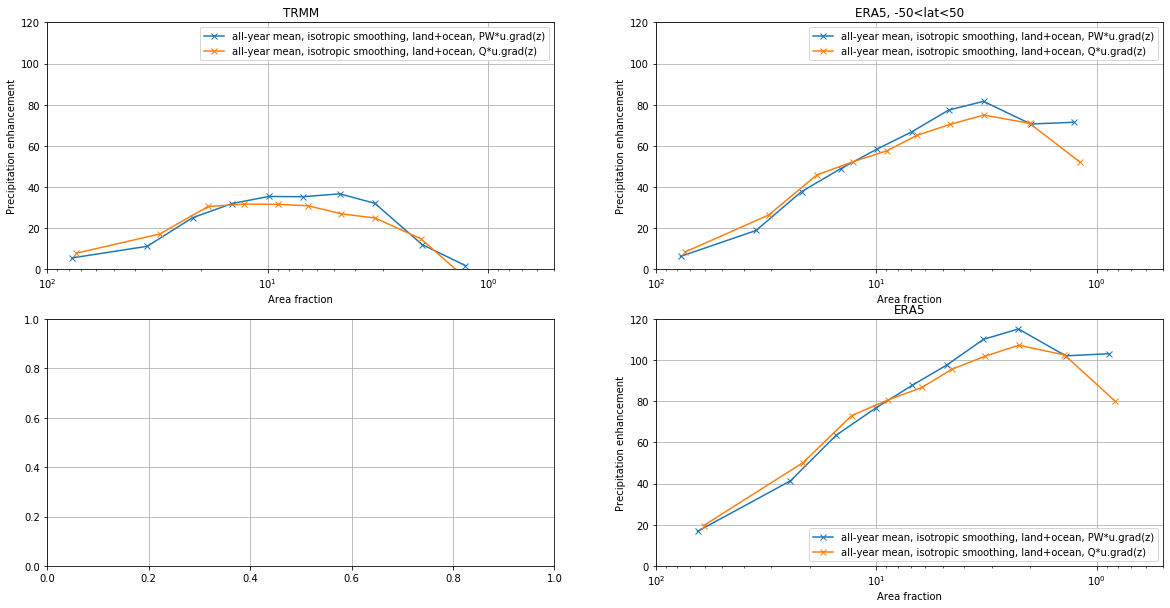

In [33]:
_,ax = plt.subplots(2,2,figsize=(20,10))

plotpct(ax[0][0],objfunction_iso_smoothing,"all-year mean, isotropic smoothing, land+ocean, PW*u.grad(z)",[pr_trmm_mean,pw_ugradz_era5_mean_s   ,landmask])
plotpct(ax[0][0],objfunction_iso_smoothing,"all-year mean, isotropic smoothing, land+ocean, Q*u.grad(z)", [pr_trmm_mean,q925_ugradz_era5_mean_s ,landmask])
ax[0][0].set_title("TRMM")
ax[0][0].set_ylim(0,120)

plotpct(ax[0][1],objfunction_iso_smoothing,"all-year mean, isotropic smoothing, land+ocean, PW*u.grad(z)",[pr_era5_mean.sel(latitude=slice(50,-50)),pw_ugradz_era5_mean_s   ,landmask])
plotpct(ax[0][1],objfunction_iso_smoothing,"all-year mean, isotropic smoothing, land+ocean, Q*u.grad(z)", [pr_era5_mean.sel(latitude=slice(50,-50)),q925_ugradz_era5_mean_s ,landmask])
ax[0][1].set_title("ERA5, -50<lat<50")
ax[0][1].set_ylim(0,120)


plotpct(ax[1][1],objfunction_iso_smoothing,"all-year mean, isotropic smoothing, land+ocean, PW*u.grad(z)",[pr_era5_mean,pw_ugradz_era5_mean_s   ,landmask])
plotpct(ax[1][1],objfunction_iso_smoothing,"all-year mean, isotropic smoothing, land+ocean, Q*u.grad(z)", [pr_era5_mean,q925_ugradz_era5_mean_s ,landmask])
ax[1][1].set_title("ERA5")
ax[1][1].set_ylim(0,120)

for a in ax.reshape(-1): a.grid()


## Seasonal means

threshold for 10% : 1.3e-04
threshold for 10% : 1.3e-04
threshold for 10% : 9.5e-05
threshold for 10% : 1.3e-04
threshold for 10% : 1.3e-04
threshold for 10% : 1.0e-04
threshold for 10% : 1.8e-04
threshold for 10% : 1.8e-04
threshold for 10% : 1.4e-04
threshold for 10% : 1.2e-04
threshold for 10% : 1.2e-04
threshold for 10% : 9.6e-05


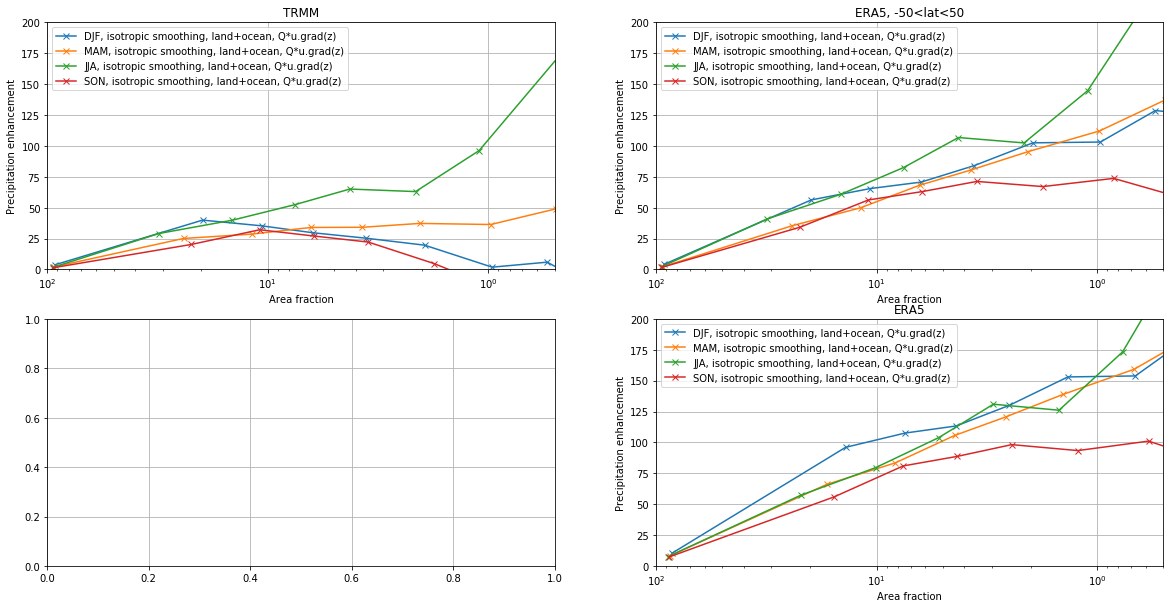

In [34]:
_,ax = plt.subplots(2,2,figsize=(20,10))

for season,seasonname in enumerate(['DJF','MAM','JJA','SON']):
    plotpct(ax[0][0],objfunction_iso_smoothing,"%s, isotropic smoothing, land+ocean, Q*u.grad(z)"%seasonname,[pr_trmm_seasonal[season],q925_ugradz_era5_seasonal[season] ,landmask])
    ax[0][0].set_ylim(0,200)
    ax[0][0].set_title("TRMM")
    
    plotpct(ax[0][1],objfunction_iso_smoothing,"%s, isotropic smoothing, land+ocean, Q*u.grad(z)"%seasonname,[pr_era5_seasonal[season].sel(latitude=slice(50,-50)),q925_ugradz_era5_seasonal[season] ,landmask])
    ax[0][1].set_title("ERA5, -50<lat<50")
    ax[0][1].set_ylim(0,200)
    
    plotpct(ax[1][1],objfunction_iso_smoothing,"%s, isotropic smoothing, land+ocean, Q*u.grad(z)"%seasonname,[pr_era5_seasonal[season],q925_ugradz_era5_seasonal[season] ,landmask])
    ax[1][1].set_title("ERA5")
    ax[1][1].set_ylim(0,200)

for a in ax.reshape(-1): a.grid()
    

# Maps

In [35]:
def plot_pr_mask(ax,thresh,pr,predictor,globmask):
    dx = np.abs(np.array(predictor.latitude[1]-predictor.latitude[0])) #get the spatial resolution of the predictor to smooth accordingly
    mask=1.*(xr.apply_ufunc(gaussian_filter,1.*(predictor>thresh),kwargs={"sigma":0.5/dx})>0.1)
    mask=mask.interp_like(pr)
    if type(globmask)!=int:
        globmask = globmask.interp_like(pr)
    m=12.
    (globmask*pr).plot(ax=ax,transform=ccrs.PlateCarree(),levels=np.linspace(0.,m,50),add_colorbar=False) #,cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,m+1,m/4)}
    kw = {'levels':[0.5], 'colors':['w']}
    mask.plot.contour(ax=ax,transform=ccrs.PlateCarree(),**kw)
    ax.coastlines()
    print("Area fraction = %.2f %%"%(100*spatial_mean(mask*globmask)/spatial_mean(globmask)))
    
def plot_pr_anisotropic_mask(ax,thresh,pr,predictor,kernel):
    unsmoothed_xr=1.*(predictor>thresh)
    t=time.time()
    rainyregion_smoothed = 1.*(convolveCustom(np.array(unsmoothed_xr),kernel)>0.01)
    print(time.time()-t)
    mask=xr.DataArray(rainyregion_smoothed,unsmoothed_xr.coords)
    mask=mask.interp_like(pr)
    
    m=12.
    pr.plot(ax=ax,transform=ccrs.PlateCarree(),levels=np.linspace(0.,m,50),add_colorbar=False)#,cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,m+1,m/4)}
    kw = {'levels':[0.5], 'colors':['w']}
    mask.plot.contour(ax=ax,transform=ccrs.PlateCarree(),**kw)
    ax.coastlines()    
    print("Area fraction = %.2f %%"%(100*spatial_mean(mask)))

Area fraction = 9.92 %
Area fraction = 6.11 %
Area fraction = 7.46 %
Area fraction = 12.42 %
Area fraction = 9.17 %


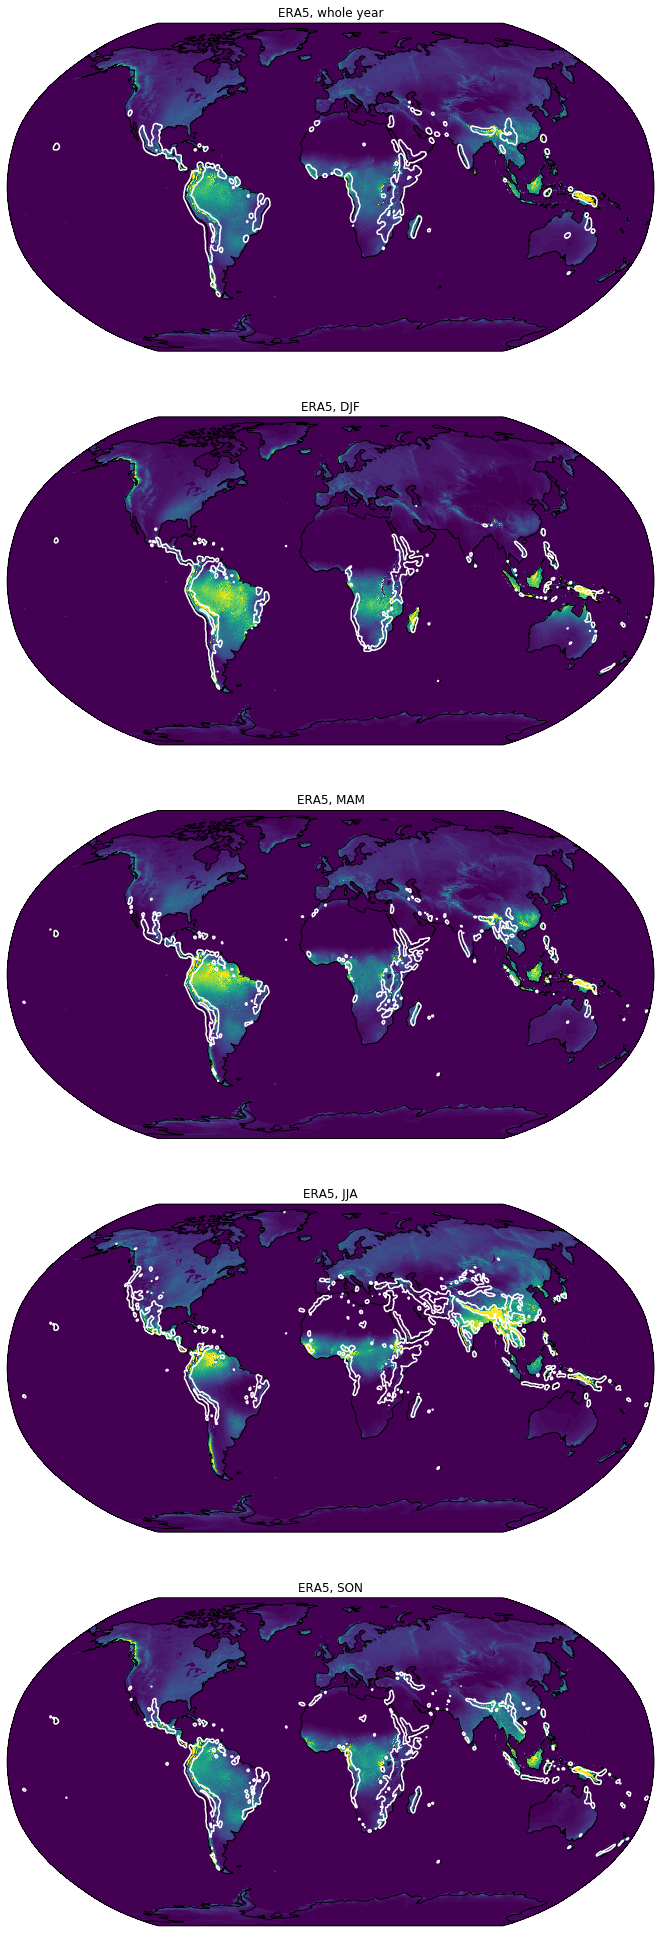

In [36]:

fig, ax = plt.subplots(5,1,figsize=(15,35),subplot_kw={'projection': ccrs.Robinson()})
plot_pr_mask(ax[0],3.9e-5,pr_era5_mean,q925_ugradz_era5_mean_s,landmask)
ax[0].set_title("ERA5, whole year")

threshs = [1.4e-04,1.2e-04,1.2e-04,9.6e-05]
for season,seasonname in enumerate(['DJF','MAM','JJA','SON']):
    plot_pr_mask(ax[season+1],threshs[season],pr_era5_seasonal[season],q925_ugradz_era5_seasonal[season],landmask)
    ax[season+1].set_title("ERA5, %s"%seasonname)


#for a in ax.reshape(-1): a.coastlines()

Area fraction = 8.18 %
17.997369289398193
Area fraction = 9.54 %
Area fraction = 6.25 %


IndexError: list index out of range

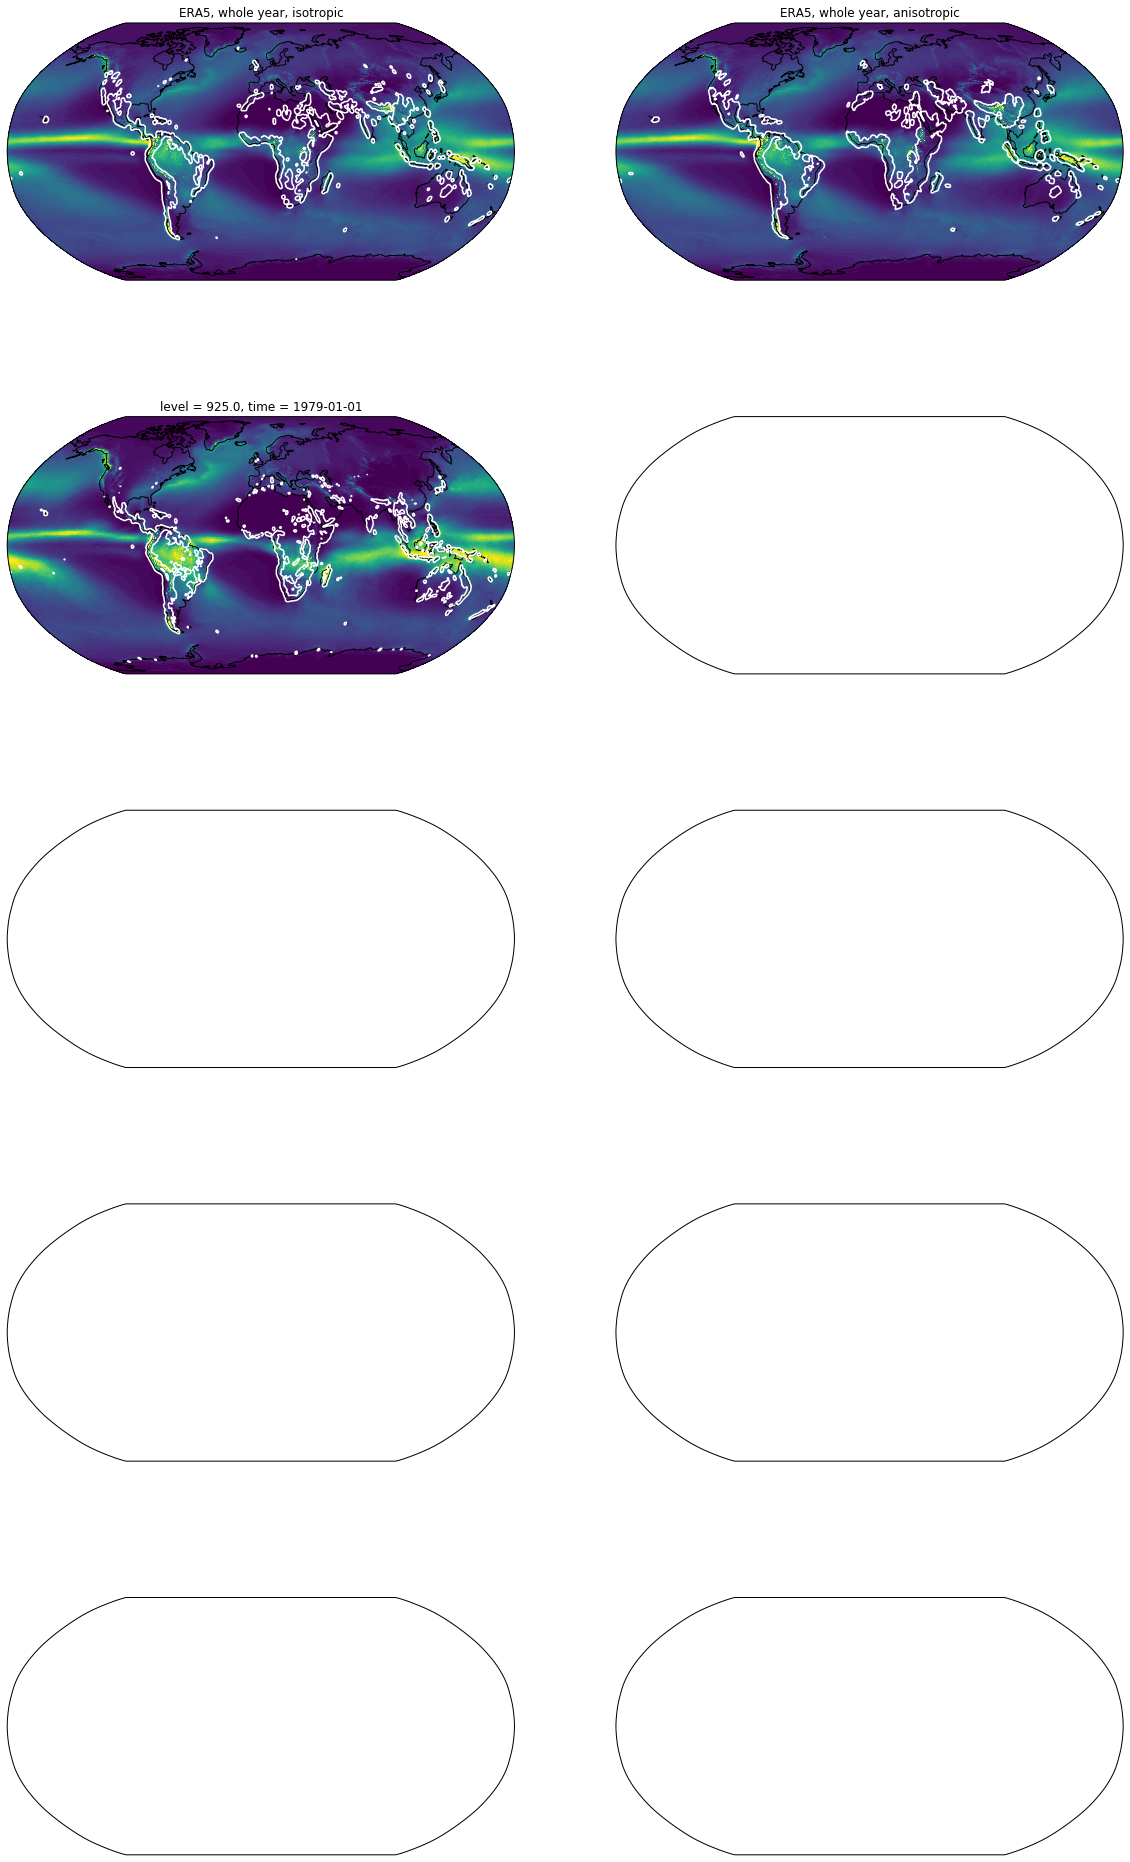

In [37]:

fig, ax = plt.subplots(5,2,figsize=(20,35),subplot_kw={'projection': ccrs.Robinson()})
plot_pr_mask(ax[0][0],1.4e-05,pr_era5_mean,q925_ugradz_era5_mean_s,1)
plot_pr_anisotropic_mask(ax[0][1],2.1e-05,pr_era5_mean,q925_ugradz_era5_mean_s,kernel_mean)
ax[0][0].set_title("ERA5, whole year, isotropic")
ax[0][1].set_title("ERA5, whole year, anisotropic")

threshs = [4.5e-05,3e-05,5e-05,4.8e-05]
threshs_aniso = [5.9e-05,6.7e-05,1.1e-04,6.5e-05]
for season,seasonname in enumerate(['DJF','MAM','JJA','SON']):
    plot_pr_mask(ax[season+1][0],threshs[season],pr_era5_seasonal[season],q925_ugradz_era5_seasonal[season],1)
    plot_pr_anisotropic_mask(ax[season+1][1],threshs_aniso[season],pr_era5_seasonal[season],q925_ugradz_era5_seasonal[season],kernel_seasonal[season])
    ax[season+1][0].set_title("ERA5, %s, isotropic"%seasonname)
    ax[season+1][1].set_title("ERA5, %s, anisotropic"%seasonname)



# Precip vs max(PW.U.grad(z)/2km,0)

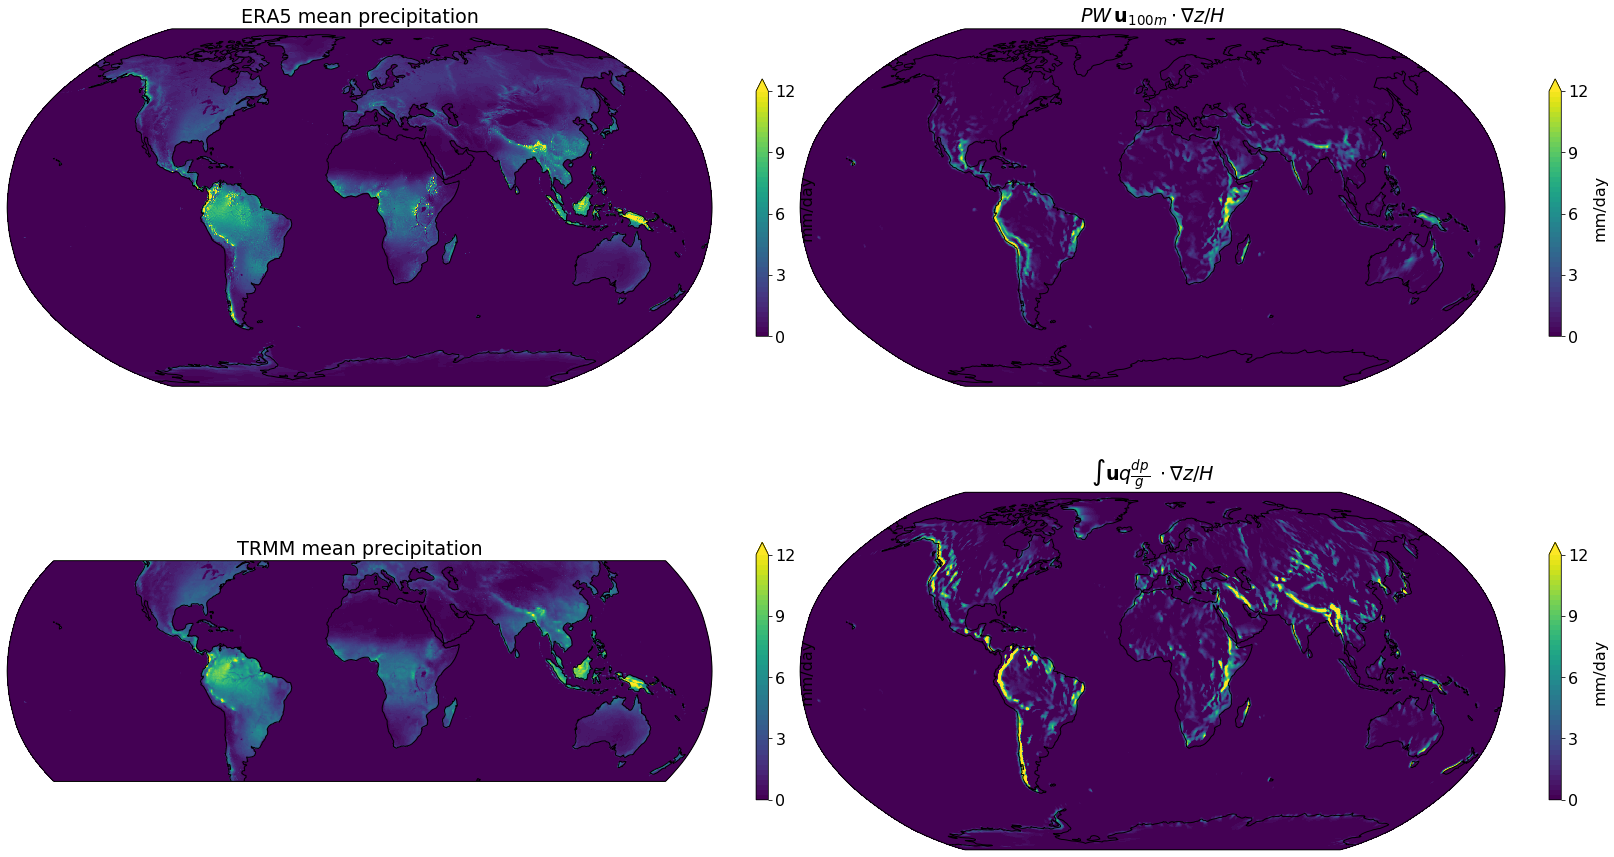

In [74]:
H=2500

fig, ax = plt.subplots(2,2,figsize=(30,18),subplot_kw={'projection': ccrs.Robinson()})
ax=ax.reshape(-1)

m=12.
(pr_era5_mean*landmask).plot(ax=ax[0],transform=ccrs.PlateCarree(),                               cbar_kwargs={"label":"mm/day","ticks":np.arange(0.,m+1,m/4),'shrink':0.5},levels=np.linspace(0.,m))
(pr_trmm_mean*landmask.interp_like(pr_trmm_mean)).plot(ax=ax[2],transform=ccrs.PlateCarree(),     cbar_kwargs={"label":"mm/day","ticks":np.arange(0.,m+1,m/4),'shrink':0.5},levels=np.linspace(0.,m))
(86400/H*xr.ufuncs.maximum(pw_ugradz_era5_mean_s,0.)).plot(ax=ax[1],transform=ccrs.PlateCarree(), cbar_kwargs={"label":"mm/day","ticks":np.arange(0.,m+1,m/4),'shrink':0.5},levels=np.linspace(0.,m))
(86400/H*xr.ufuncs.maximum(vimt_gradz_era5_mean_s,0.)).plot(ax=ax[3],transform=ccrs.PlateCarree(),cbar_kwargs={"label":"mm/day","ticks":np.arange(0.,m+1,m/4),'shrink':0.5},levels=np.linspace(0.,m))

titles=["ERA5 mean precipitation",r"$PW\, \mathbf{u}_{100m}\cdot\nabla z / H$" ,"TRMM mean precipitation",r"$\int \mathbf{u}q \frac{dp}{g}\;\cdot\nabla z / H$"]

for i,a in enumerate(ax) :
    a.coastlines()
    a.set_title(titles[i])
plt.subplots_adjust(hspace=-0.1,wspace=-0.1)
    

# Figures for Ruby

In [57]:
def plot_pr_mask(ax,thresh,pr,predictor,globmask):
    dx = np.abs(np.array(predictor.latitude[1]-predictor.latitude[0])) #get the spatial resolution of the predictor to smooth accordingly
    mask=1.*(xr.apply_ufunc(gaussian_filter,1.*(predictor>thresh),kwargs={"sigma":0.5/dx})>0.1)
    mask=mask.interp_like(pr)
    if type(globmask)!=int:
        globmask = globmask.interp_like(pr)
    m=12.
    (globmask*pr).plot(ax=ax,transform=ccrs.PlateCarree(),levels=np.linspace(0.,m,50),add_colorbar=False) #,cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,m+1,m/4)}
    kw = {'levels':[0.5], 'colors':['w']}
    mask.plot.contour(ax=ax,transform=ccrs.PlateCarree(),**kw)
    ax.coastlines()
    print("Area fraction = %.2f %%"%(100*spatial_mean(mask*globmask)/spatial_mean(globmask)))

In [63]:
matplotlib.rcParams.update({'font.size': 20})

Area fraction = 7.00 %


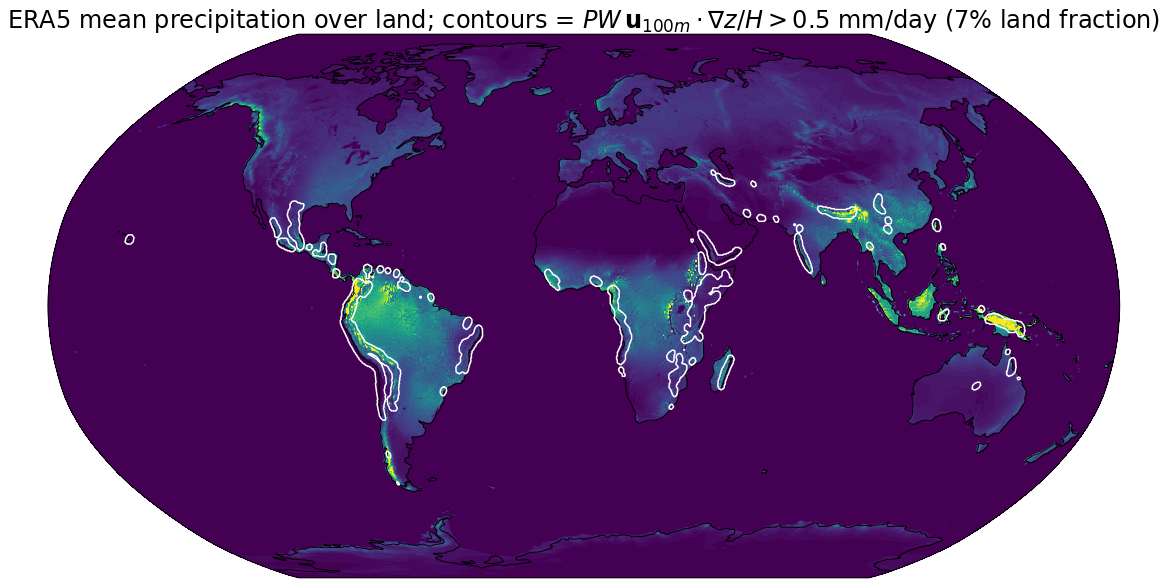

In [64]:
fig, ax = plt.subplots(1,1,figsize=(20,10),subplot_kw={'projection': ccrs.Robinson()})
plot_pr_mask(ax,0.144,pr_era5_mean,pw_ugradz_era5_mean_s,landmask)
ax.set_title("ERA5 mean precipitation over land; contours = "+r"$PW\, \mathbf{u}_{100m}\cdot\nabla z / H > 0.5$ mm/day (7% land fraction)")
matplotlib.rcParams.update({'font.size': 20})

In [69]:
def plotpct(ax,objfunction,lbl,args,color=0):
    #Get the range of thresholds to use on the predictor
    predictor = args[1]
    maxtresh = 0.5*np.max(np.array(predictor))
    ts = np.linspace(0.,maxtresh,10)
    
    x = np.array([objfunction(*tuple([t]+list(args))) for t in ts])
    precip_enhancements = x[:,0]
    area_fractions = x[:,1]
    
    print("threshold for 10%% : %.1e"%np.interp(10,area_fractions[::-1],ts[::-1]))
    
    if color==0:
        ax.plot(area_fractions,precip_enhancements,'-x',label=lbl)
    else:
        ax.plot(area_fractions,precip_enhancements,'-x',label=lbl,color=color)
    ax.set_xscale('log')
    ax.set_xlim(100,0.5)

    ax.legend()
    ax.set_xlabel("Land fraction (%)")
    ax.set_ylabel("Precipitation enhancement (%)")
    ax.grid()

threshold for 10% : 1.3e-04
threshold for 10% : 9.5e-05
threshold for 10% : 1.3e-04
threshold for 10% : 1.0e-04
threshold for 10% : 1.8e-04
threshold for 10% : 1.4e-04
threshold for 10% : 1.2e-04
threshold for 10% : 9.6e-05
threshold for 10% : 1.5e-01
threshold for 10% : 1.5e-01


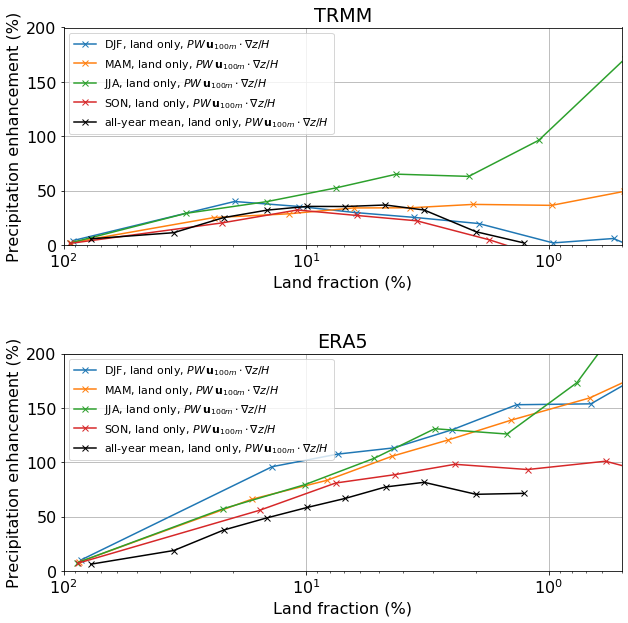

In [72]:
matplotlib.rcParams.update({'font.size': 16})
_,ax = plt.subplots(2,1,figsize=(10,10))

for season,seasonname in enumerate(['DJF','MAM','JJA','SON']):
    plotpct(ax[0],objfunction_iso_smoothing,"%s, land only, "%seasonname + r"$PW\, \mathbf{u}_{100m}\cdot\nabla z / H$",[pr_trmm_seasonal[season],q925_ugradz_era5_seasonal[season] ,landmask])
    ax[0].set_ylim(0,200)
    ax[0].set_title("TRMM")
    plotpct(ax[1],objfunction_iso_smoothing,"%s, land only, "%seasonname + r"$PW\, \mathbf{u}_{100m}\cdot\nabla z / H$",[pr_era5_seasonal[season],q925_ugradz_era5_seasonal[season] ,landmask])
    ax[1].set_title("ERA5")
    ax[1].set_ylim(0,200)
    
plotpct(ax[0],objfunction_iso_smoothing,"all-year mean, land only, " + r"$PW\, \mathbf{u}_{100m}\cdot\nabla z / H$",[pr_trmm_mean,pw_ugradz_era5_mean_s   ,landmask],color='k')
plotpct(ax[1],objfunction_iso_smoothing,"all-year mean, land only, " + r"$PW\, \mathbf{u}_{100m}\cdot\nabla z / H$",[pr_era5_mean.sel(latitude=slice(50,-50)),pw_ugradz_era5_mean_s   ,landmask],color='k')


for a in ax.reshape(-1): a.grid()
matplotlib.rcParams.update({'font.size': 16})
ax[0].legend(prop={"size":11})
ax[1].legend(prop={"size":11})

plt.subplots_adjust(hspace=0.5)


for a in ax.reshape(-1): a.grid()
